<a href='https://www.moh.gov.sa/en/Pages/Default.aspx'> <img style="float: left;height:70px" src="http://scienceacademy.ca/wp-content/uploads/2018/12/Logo_SA.png"></a>

Instructor and author: [_Dr. Junaid Qazi_](https://www.linkedin.com/in/jqazi/)

Hello guys, 

Having twitter account is a common practice in this era of social media, and many individuals express their feeling via their twitter accounts. This might be a good idea to see how Neural Networks can help us to extract or classify tweets for certain sentiment. 

`==>` *Tweets data is available at [kaggle](https://www.kaggle.com/c/tweet-sentiment-extraction/overview) and there is a prize money for the winners!*

At this stage, we all know that that [TensorFlow](https://www.tensorflow.org/) is a wonderful end-to-end open source platform for machine learning. Let's use this amazing platform to train a simple Convolutional Neural Network -- CNN and see if we can classify tweets into "`positive`","`negative`" and "`neutral`" sentiment! 

>Please note, I expect all of you to print message to update the status and progress of the process in this exercise. You can see several messages in the output to lead the user.....!

In [1]:
# Starting with the required imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter

# sklearn imports
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

# some tensorflow imports
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential,regularizers,losses
from tensorflow.keras.layers import Embedding,Conv1D,GlobalMaxPooling1D,Dropout,Dense

#Setting display format to retina in matplotlib to see better quality images.
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

# just to ignore warnings
import warnings; warnings.filterwarnings('ignore')

<ipython-input-1-fe5f2b34d31b>:22: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina')


In the cell below, I am importing some custom functions that I have placed in a directory name `custom_funcs` inside the current working directory. *Recall your python lecture on functions, where we learned to do this!*

In [2]:
# importing custom function from working directory
from custom_funcs.remove_emoji import remove_emoji 
from custom_funcs.remove_urls import remove_url
from custom_funcs.clean_tweet_text import clean_text

In [3]:
# Just making sure we are working with TF-2
import tensorflow as tf
print("the current tensorflow version in use is: ",tf.__version__)

the current tensorflow version in use is:  2.5.0


**reading the data from git.** *(you can download the file for off-line usage.)* 

In [4]:
train_url="""https://raw.githubusercontent.com/junaidqazi/\
DataSets_Practice_ScienceAcademy/master/Tweets_Sentiment_Analysis/train.csv"""
df= pd.read_csv(train_url)

**the data overview using `.info()`.** 

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


**looks like there is some missing data (only one tweet), let's drop it!**

*by the way, what would be your strategy if a small fraction is missing?*

In [6]:
#code here please
df.isnull().sum().sort_values(ascending=False)

text             1
selected_text    1
textID           0
sentiment        0
dtype: int64

In [7]:
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27480 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27480 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27480 non-null  object
dtypes: object(4)
memory usage: 1.0+ MB


**What is the minimum and maximum length (how many words) of a single tweet?** 

In [8]:
#code here please
df['tweetLength'] = df['text'].str.split().str.len()
min = df['tweetLength'].min()
max = df['tweetLength'].max()
print(f'Min Tweet length: {min}')
print(f'Max Tweet length: {max}')

Min Tweet length: 1
Max Tweet length: 33


**Select only the tweets that are more than 2 words long.** *(recall masking from dataframes lecture)*

In [9]:
df.head()

,textID,text,selected_text,sentiment,tweetLength
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,7
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,10
2,088c60f138,my boss is bullying me...,bullying me,negative,5
3,9642c003ef,what interview! leave me alone,leave me alone,negative,5
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,14


In [10]:
df['Greater_two'] = df['tweetLength'] > 2
df['Greater_two'] = df['Greater_two'].replace(False, np.NAN)
df.dropna(inplace=True)
g2 = df['Greater_two'].value_counts()
print('Training dataset:')
print(f'Number of tweets having more than 2 words: {g2}')
g3 = df['sentiment'].value_counts()
print(f'Class count:\n{g3}')

Training dataset:
Number of tweets having more than 2 words: True    26752
Name: Greater_two, dtype: int64
Class count:
neutral     10704
positive     8375
negative     7673
Name: sentiment, dtype: int64


**Clean the data please.**
* remove emoji
* remove urls
* clean the text 

In [11]:
#code here please
df['text'] = df['text'].apply(remove_emoji)
print(f'training data -- removing emoji....')
df['text'] = df['text'].apply(remove_url)
print(f'training data -- removing urls....')
df['text'] = df['text'].apply(clean_text)
print(f'training data -- cleaning text....')
df.head(1)

training data -- removing emoji....
training data -- removing urls....
training data -- cleaning text....


,textID,text,selected_text,sentiment,tweetLength,Greater_two
0,cb774db0d1,have responded were going,"I`d have responded, if I were going",neutral,7,True


*A quick question to see if you are still with me! Why the number in n_words is different than the word count in text column?*

#### Working with the train part of the data.

Let us split the training data into train and validation datasets
Let us convert our training,validation and test data into the format accepted by tensorflow

**Initialize the [tokenizer](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer) and fit to the text column.**

*(from TF documentation) This class allows to vectorize a text corpus, by turning each text into either a sequence of integers (each integer being the index of a token in a dictionary) or into a vector where the coefficient for each token could be binary, based on word count, based on tf-idf...*

***please set `oov_token='unknown'` while creating `Tokenizer` instances, can you explain this parameter?*** *(hint: out-of-vocabulary)*

In [12]:
#code here please
print(f'Max words to keep: 20000')
tokenizer = Tokenizer(num_words=20000, oov_token='unknown')
print(f'token initilized....')
tokenizer.fit_on_texts(df['text'])
print(f'fitting on tweets...')
print(f'Done!')

Max words to keep: 20000
token initilized....
fitting on tweets...
Done!


**please check the index of 'unknown'**

In [13]:
#code here please
index = tokenizer.word_index['unknown']
print(f'Index of word \'unknown\' is {index}')

Index of word 'unknown' is 5284


**(extra learning question) Get the sequence for `'I am Junaid; xyz how are you -- unknown'`**

*What do you see, explain the reason to have same number for several words?*

In [14]:
#code here please
tokenizer.texts_to_sequences(['I am Juaid; xyz hhow are you -- unknown'])

[[5284, 5284, 5284, 5284, 5284, 21, 4, 5284]]

**Split the data into train and test part.**

Class is imbalanced, how will you handle this without re-sampling? 

In [15]:
df.head()

,textID,text,selected_text,sentiment,tweetLength,Greater_two
0,cb774db0d1,have responded were going,"I`d have responded, if I were going",neutral,7,True
1,549e992a42,sooo sad will miss you here san diego,Sooo SAD,negative,10,True
2,088c60f138,boss bullying,bullying me,negative,5,True
3,9642c003ef,what interview leave alone,leave me alone,negative,5,True
4,358bd9e861,sons why couldnt they put them the releases al...,"Sons of ****,",negative,14,True


In [16]:
#code here please
X = df['text']
y = df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.1, random_state = 101, stratify = y)
print(f'X_train length:')
display(len(X_train))
print(f'y_train:')
display(y_train.value_counts().to_dict())
print(f'X_test length:')
display(len(X_test))
print(f'y_train:')
display(y_test.value_counts().to_dict())

X_train length:


24076

y_train:


{'neutral': 9633, 'positive': 7537, 'negative': 6906}

X_test length:


2676

y_train:


{'neutral': 1071, 'positive': 838, 'negative': 767}

**Get sequences and pad them with max_tweet_length (I am using `maxlen=36`).**

`==>` Learning trick: 

* try different values of `maxlen` and observe the difference in the model performance and compute/training time.
* try using list of tokens and arrays of tokens to see the difference in training.

In [17]:
#Code here please
# Should I replace 36 with the actual maxlen of Xtrain?
ps_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen = 36, padding = 'post')
ps_test = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen = 36, padding = 'post')

display(type(ps_train))
display(type(ps_test))

display(ps_train[0])
len(ps_train[0])

numpy.ndarray

numpy.ndarray

array([ 151,   83,  109,  248,  172,  135,  207, 5284,    2,  775,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0], dtype=int32)

36

**Encode the labels/targets in appropriate format for TF.**

In [18]:
#code here please

le  = LabelEncoder()

y_train_temp = y_train
y_test_temp = y_test

print(f'y_train Output:')
display(y_train[0:5])
y_train_temp = le.fit_transform(y_train_temp)
display(y_train_temp[0:5])

print(f'y_test Output:')
display(y_test[0:5])
y_test_temp = le.fit_transform(y_test_temp)
display(y_test_temp[0:5])

# Convert to arrays of binary encoding

print(f'Binary Encoding:')
y_train_temp = np.asarray(tf.keras.utils.to_categorical(y_train_temp))
y_test_temp = np.asarray(tf.keras.utils.to_categorical(y_test_temp))

# DO NOT NEED
#binz = LabelBinarizer()
#y_train_temp = binz.fit_transform(y_train_temp)
#y_test_temp = binz.fit_transform(y_test_temp)

display(y_train_temp[0:2])
display(y_test_temp[0:2])

y_train = y_train_temp
y_test = y_test_temp

y_train Output:


22509    positive
27375     neutral
8114      neutral
23958     neutral
14664     neutral
Name: sentiment, dtype: object

array([2, 1, 1, 1, 1])

y_test Output:


5234     positive
840      positive
19094     neutral
16177    positive
26499    negative
Name: sentiment, dtype: object

array([2, 2, 1, 2, 0])

Binary Encoding:


array([[0., 0., 1.],
       [0., 1., 0.]], dtype=float32)

array([[0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

**In the above train and test encoded labels, which sentiment they are representing?**

In [19]:
#Ans: they are representing negative, neutral, and positive

**what is the purpose of [tf.data.Dataset.from_tensor_slices](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) explore the documentation.**

In [20]:
#code here please
train_ds = tf.data.Dataset.from_tensor_slices(ps_train)
test_ds  = tf.data.Dataset.from_tensor_slices(ps_test)
print(f'train_ds is {type(train_ds)}')
print(f'test_ds is {type(test_ds)}')

train_ds is <class 'tensorflow.python.data.ops.dataset_ops.TensorSliceDataset'>
test_ds is <class 'tensorflow.python.data.ops.dataset_ops.TensorSliceDataset'>


**Please print first two observations in the train and test part.** 

*please use `for loop` with `break` statement ...*

In [21]:
#code here please
for el in train_ds:
    print(f'-----------------\n train data part\n-----------------')
    print(el)
    break
for el in test_ds:
    print(f'-----------------\n test data part\n-----------------')
    print(el)
    break

-----------------
 train data part
-----------------
tf.Tensor(
[ 151   83  109  248  172  135  207 5284    2  775    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0], shape=(36,), dtype=int32)
-----------------
 test data part
-----------------
tf.Tensor(
[  34   51   11 1698 3968 1150    3 1829   22   23 2201 7643    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0], shape=(36,), dtype=int32)


**Create a simple CNN -- Convolutional Neural Network using [sequential API](https://www.tensorflow.org/guide/keras/sequential_model).**

*(from TF documentation) A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor.*

In [22]:
max_features =20000
embedding_dim =100
sequence_length = 36 # equal to max lenght with padding

model = Sequential()
#Embedding layer
model.add(Embedding(max_features +1, # recall the reson of +1 from lecture
                    embedding_dim,
                    input_length=sequence_length,
                    embeddings_regularizer=regularizers.l2(0.0005)))                                    
# first Conv1D layer
model.add(Conv1D(128,3,activation='relu',
                 kernel_regularizer=regularizers.l2(0.0005),
                 bias_regularizer=regularizers.l2(0.0005)))                               
#GlobalMaxPooling1D
model.add(GlobalMaxPooling1D())
# dropput layer 
model.add(Dropout(0.5))
# Dense layer
model.add(Dense(3, activation='sigmoid',
                kernel_regularizer=regularizers.l2(0.001),
                bias_regularizer=regularizers.l2(0.001),))
#Compileing model
model.compile(loss=losses.CategoricalCrossentropy(from_logits=True),
              optimizer='Nadam', metrics=["CategoricalAccuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 36, 100)           2000100   
_________________________________________________________________
conv1d (Conv1D)              (None, 34, 128)           38528     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 3)                 387       
Total params: 2,039,015
Trainable params: 2,039,015
Non-trainable params: 0
_________________________________________________________________


**can you justify the  total number of parameters in your model summary?**

In [23]:
#Ans: Yes, 

**Train your network** Use 100 epochs, 

In [24]:
#code here please
model.fit?

In [25]:
print(f'X_train: {ps_train.shape}')
print(f'y_train: {y_train.shape}')

print(f'X_test: {ps_test.shape}')
print(f'y_test: {y_test.shape}')

X_train: (24076, 36)
y_train: (24076, 3)
X_test: (2676, 36)
y_test: (2676, 3)


In [26]:
model.fit(
    ps_train,
    y_train,
    epochs=100,
    use_multiprocessing=True,
    validation_data=(ps_test,y_test),
    verbose=1,
    )

Epoch 1/100
753/753 [==============================] - 17s 20ms/step - loss: 0.9344 - categorical_accuracy: 0.6349 - val_loss: 0.8454 - val_categorical_accuracy: 0.6865
Epoch 2/100
753/753 [==============================] - 15s 19ms/step - loss: 0.8178 - categorical_accuracy: 0.7124 - val_loss: 0.8420 - val_categorical_accuracy: 0.7007
Epoch 3/100
753/753 [==============================] - 14s 19ms/step - loss: 0.8007 - categorical_accuracy: 0.7260 - val_loss: 0.8465 - val_categorical_accuracy: 0.7029
Epoch 4/100
753/753 [==============================] - 14s 19ms/step - loss: 0.7918 - categorical_accuracy: 0.7338 - val_loss: 0.8533 - val_categorical_accuracy: 0.7022
Epoch 5/100
753/753 [==============================] - 14s 19ms/step - loss: 0.7738 - categorical_accuracy: 0.7447 - val_loss: 0.8729 - val_categorical_accuracy: 0.6996
Epoch 6/100
753/753 [==============================] - 14s 19ms/step - loss: 0.7632 - categorical_accuracy: 0.7574 - val_loss: 0.8772 - val_categorical_acc

753/753 [==============================] - 13s 18ms/step - loss: 0.5234 - categorical_accuracy: 0.9230 - val_loss: 1.1727 - val_categorical_accuracy: 0.6693
Epoch 50/100
753/753 [==============================] - 13s 18ms/step - loss: 0.5226 - categorical_accuracy: 0.9214 - val_loss: 1.1805 - val_categorical_accuracy: 0.6749
Epoch 51/100
753/753 [==============================] - 13s 18ms/step - loss: 0.5220 - categorical_accuracy: 0.9224 - val_loss: 1.1812 - val_categorical_accuracy: 0.6678
Epoch 52/100
753/753 [==============================] - 13s 18ms/step - loss: 0.5201 - categorical_accuracy: 0.9252 - val_loss: 1.1822 - val_categorical_accuracy: 0.6723
Epoch 53/100
753/753 [==============================] - 13s 17ms/step - loss: 0.5203 - categorical_accuracy: 0.9241 - val_loss: 1.1897 - val_categorical_accuracy: 0.6685
Epoch 54/100
753/753 [==============================] - 13s 17ms/step - loss: 0.5218 - categorical_accuracy: 0.9246 - val_loss: 1.1690 - val_categorical_accuracy: 

753/753 [==============================] - 13s 17ms/step - loss: 0.5000 - categorical_accuracy: 0.9331 - val_loss: 1.1941 - val_categorical_accuracy: 0.6648
Epoch 98/100
753/753 [==============================] - 13s 17ms/step - loss: 0.5007 - categorical_accuracy: 0.9335 - val_loss: 1.1774 - val_categorical_accuracy: 0.6786
Epoch 99/100
753/753 [==============================] - 13s 17ms/step - loss: 0.4974 - categorical_accuracy: 0.9337 - val_loss: 1.1774 - val_categorical_accuracy: 0.6693
Epoch 100/100
753/753 [==============================] - 13s 17ms/step - loss: 0.5010 - categorical_accuracy: 0.9332 - val_loss: 1.1782 - val_categorical_accuracy: 0.6667


In [27]:
#history is history object and model is trained cnn model
model.history.history.keys()

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])

**Re-create the plots below from history and explain the curves.**

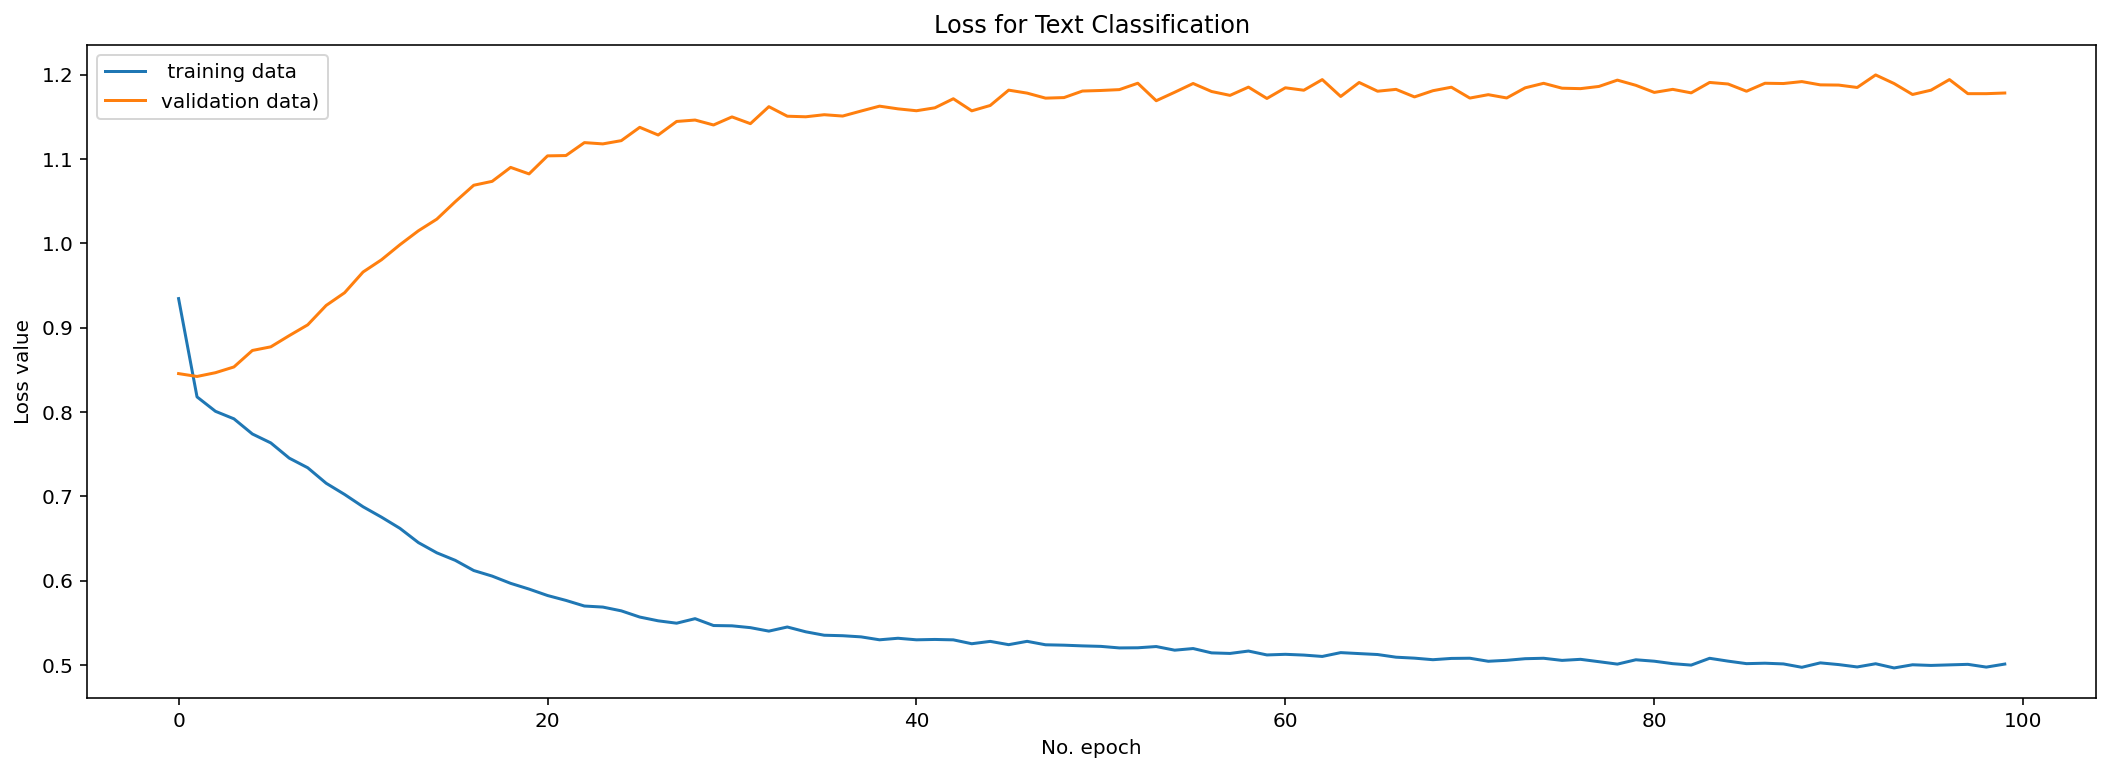

In [28]:
#code here please
plt.figure(figsize=(18,6))
plt.plot(model.history.history['loss'], label=' training data')
plt.plot(model.history.history['val_loss'], label='validation data)')
plt.title('Loss for Text Classification')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left");

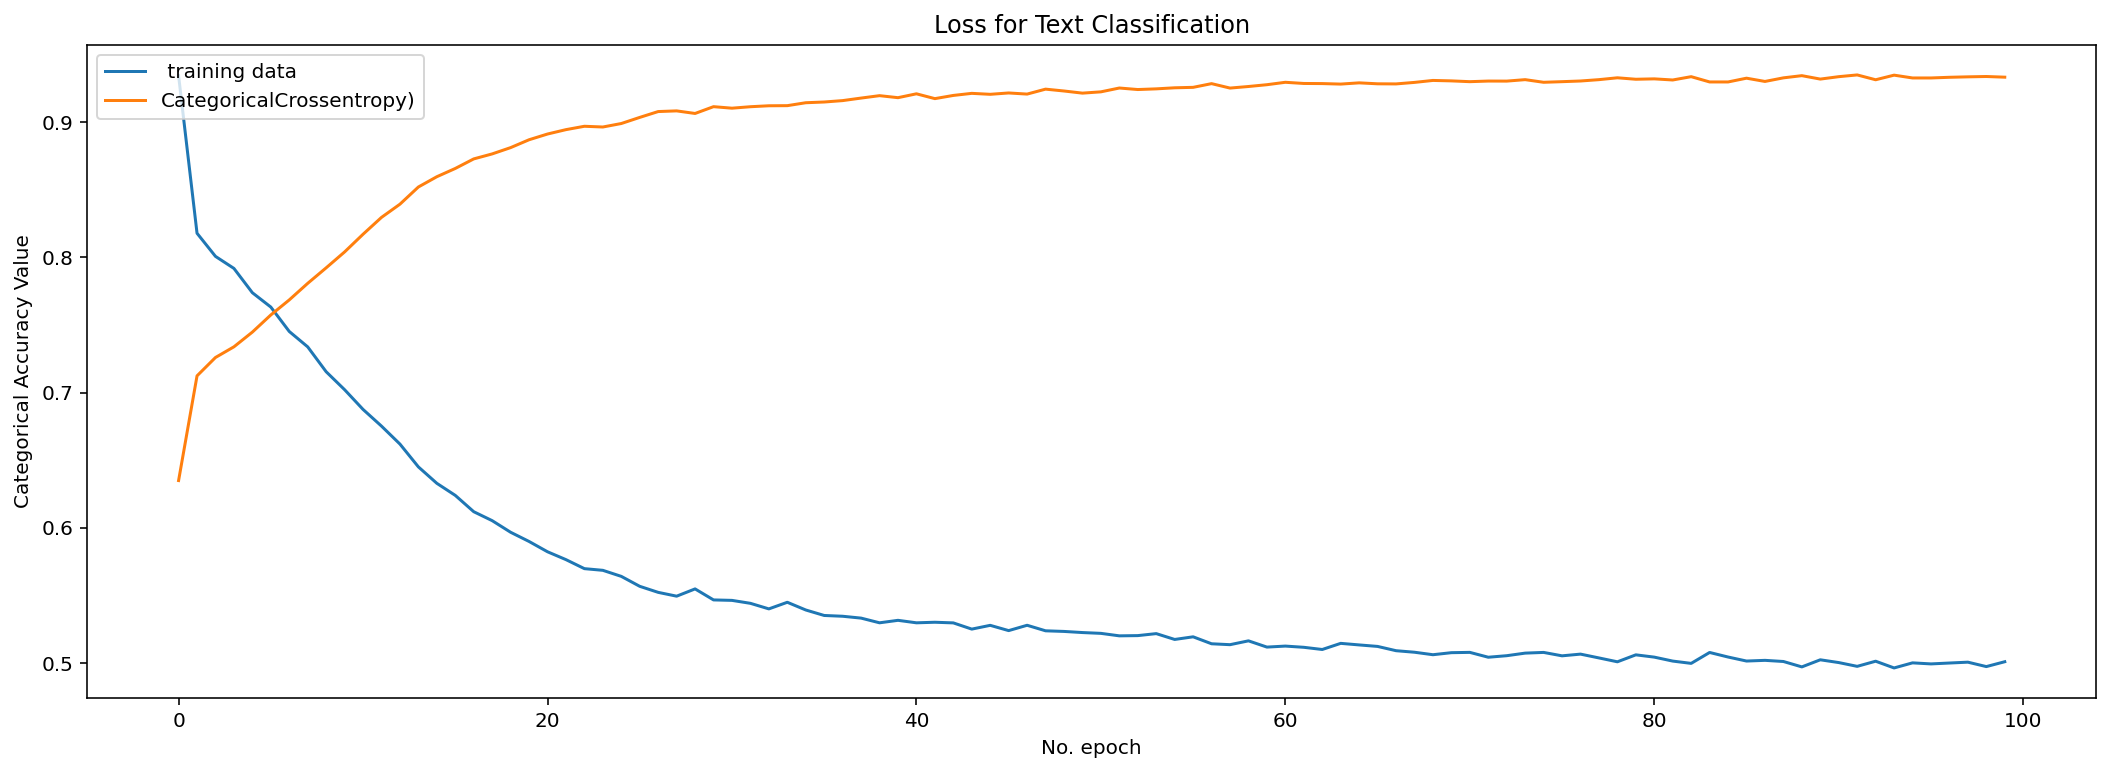

In [29]:
#code here please
plt.figure(figsize=(18,6))
plt.plot(model.history.history['loss'], label=' training data')
plt.plot(model.history.history['categorical_accuracy'], label='CategoricalCrossentropy)')
plt.title('Loss for Text Classification')
plt.ylabel('Categorical Accuracy Value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left");

**Save your trained model and the tokenizer** 

*use model.save module and convert tokenizer into json before saving -- import jason!*

In [30]:
#code here please
model.save('tensorModel')
import pickle
token = tokenizer.to_json()
with open('tokenizer.pickle','wb') as handle:
    pickle.dump(token,handle)

INFO:tensorflow:Assets written to: tensorModel/assets


`==>`learning trick: open the saved tokenizer.json and look for some word, what do you see for unknown?

------------
------------
------------
## Here the test data comes in -- your 2nd file

In [31]:
test_url="""https://raw.githubusercontent.com/junaidqazi/\
DataSets_Practice_ScienceAcademy/master/Tweets_Sentiment_Analysis/test.csv"""
df2 = pd.read_csv(test_url)

In [32]:
df2.head()

,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive


**Repeat all the above steps that you have performed on the above dataset.**

In [33]:
# code here please 

# Number of tweets in test data
print(f'Num of tweets in test data: {len(df2)}')
# Any NaN values?
print(f'Droping NaN values: ')
display(df2.isnull().sum().sort_values(ascending=False))
# Checking Min and Max Tweets
df2['tweetLength'] = df2['text'].str.split().str.len()
min = df2['tweetLength'].min()
max = df2['tweetLength'].max()
print(f'Min Tweet length: {min}')
print(f'Max Tweet length: {max}')
# removing all that are less than two words
df2['Greater_two'] = df2['tweetLength'] > 2
df2['Greater_two'] = df2['Greater_two'].replace(False, np.NAN)
df2.dropna(inplace=True)
output = df2['Greater_two'].value_counts()
print(f'Number of tweets having more than 2 words: {output}')
# Print num of tweets greater than 2
print(f'Class Count')
display(df2['sentiment'].value_counts())

# Run Functions
df2['text'] = df2['text'].apply(remove_emoji)
print(f'training data -- removing emoji....')
df2['text'] = df2['text'].apply(remove_url)
print(f'training data -- removing urls....')
df2['text'] = df2['text'].apply(clean_text)
print(f'training data -- cleaning text....')
df2.head(1)

Num of tweets in test data: 3534
Droping NaN values: 


textID       0
text         0
sentiment    0
dtype: int64

Min Tweet length: 1
Max Tweet length: 32
Number of tweets having more than 2 words: True    3434
Name: Greater_two, dtype: int64
Class Count


neutral     1376
positive    1075
negative     983
Name: sentiment, dtype: int64

training data -- removing emoji....
training data -- removing urls....
training data -- cleaning text....


,textID,text,sentiment,tweetLength,Greater_two
0,f87dea47db,last session the day,neutral,6,True


**separate data to features and labels and then transform labels into appropriate format.** 

In [34]:
#code here please
X = df2['text']
y = df2['sentiment']

# Label
le  = LabelEncoder()
print(f'y Output:')
y = le.fit_transform(y)

#display(y[0:5])
#y = np.asarray(tf.keras.utils.to_categorical(y))
#display(y[0:5])


y Output:


**load tokenizer and get the sequences and pad them with to maxlen=36, same as above**

In [35]:
#code here please
import pickle
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer_json = pickle.load(handle)

tk = tf.keras.preprocessing.text.tokenizer_from_json(
    tokenizer_json
)
# Getting Sequences for the test data and adding padding accordingly
X_seq = pad_sequences(tk.texts_to_sequences(X), maxlen = 36, padding = 'post')
display(X_seq)

array([[  68, 1077,    2, ...,    0,    0,    0],
       [5284,  209,   39, ...,    0,    0,    0],
       [4571,  391, 5284, ...,    0,    0,    0],
       ...,
       [  37,   38,    4, ...,    0,    0,    0],
       [5284,   38,   24, ...,    0,    0,    0],
       [5284, 2137,  332, ...,    0,    0,    0]], dtype=int32)

**Load the saved model and get predictions for the test data**

In [36]:
#code here please
model_load = keras.models.load_model('tensorModel')
model_load.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 36, 100)           2000100   
_________________________________________________________________
conv1d (Conv1D)              (None, 34, 128)           38528     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 3)                 387       
Total params: 2,039,015
Trainable params: 2,039,015
Non-trainable params: 0
_________________________________________________________________


**Generate predictions (probabilities -- the output of the last layer) on test  data using `predict`**

In [37]:
#code here please
display(X[0:5])
output = model_load.predict_classes(X_seq)
display(output[0:5])

0                                 last session the day
1    shanghai also really exciting precisely skyscr...
2    recession hit veronique branquinho she has qui...
4                                                 like
5                            thats great weee visitors
Name: text, dtype: object

array([1, 2, 0, 1, 2])

**Can you think about creating classification report and confusion matrix for the predictions?**

In [38]:
#code here please
display(output)
print(classification_report(y, output))

array([1, 2, 0, ..., 0, 2, 2])

              precision    recall  f1-score   support

           0       0.69      0.66      0.67       983
           1       0.63      0.69      0.66      1376
           2       0.77      0.72      0.74      1075

    accuracy                           0.69      3434
   macro avg       0.70      0.69      0.69      3434
weighted avg       0.69      0.69      0.69      3434



In [39]:
#code here please
confusion_matrix(y, output)

array([[645, 296,  42],
       [242, 943, 191],
       [ 53, 250, 772]])

## To Do:

* Think about improving the model, what can be done?
* Build LSTM network and compare the performance.

*Note: see the extension of your saved model in the folder, where you have saved the model. The`.pb` extension stands for protobuf ([protocol buffers](https://developers.google.com/protocol-buffers/)). Protocol buffers are a language-neutral, platform-neutral extensible mechanism for serializing structured data. In TensorFlow, the `.pb` is all you need to be able to run a given trained model.* 

## License{-}

Author: [___Dr. Junaid Qazi___](https://www.linkedin.com/in/jqazi/)

Twitter: [***@JunaidSQazi***](https://twitter.com/JunaidSQazi)

Copyright 2021

Licensed under the [Apache License, Version 2.0](http://www.apache.org/licenses/LICENSE-2.0) (the "License").<br>you may not use this file except in compliance with the License.
You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0

*Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. Please see the License for the specific language governing permissions and limitations under the License.*


*This is not an official product but sample code provided for an educational purpose.*

***Acknowledgement is requested***

\pagebreak